In [50]:
import pyarrow.parquet as pq
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [51]:
df = pd.read_parquet("Skim_OneSig_Oguz_Sel.parquet")

In [52]:
df["label"] = 0
df = df[df['weight']>0]

In [53]:
print(df)

        weight   Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
0     0.000025  1.151401  2.699523   1.979170    1.137842  1.603054  1.725826   
1     0.000025  0.928688 -1.035375   2.569062    1.755869  0.060377  0.110630   
2     0.000025 -0.324566 -0.605513   0.910566    0.864624  0.541065  0.405040   
3     0.000025 -1.350016 -0.786307   1.866993    0.907029 -2.300989  2.424570   
4     0.000025  0.276418  0.034514   0.957748    0.922289  1.291733  2.735958   
...        ...       ...       ...        ...         ...       ...       ...   
1850  0.784736  0.489109  1.587192   0.735345    0.655377  1.599969 -1.402752   
1851  0.784736 -0.516578 -2.108513   0.333769    0.293702  2.013005  2.914027   
1852  0.784736  1.693811  2.266197   1.222146    0.434619  0.070262 -1.049876   
1853  0.784736  0.137637  2.189009   0.418680    0.414745  2.172778  0.626050   
1854  0.784736  1.709857  0.876920   3.384164    1.185541  1.333158  2.846901   

      E_mGG_ph2  pT_mGG_ph2

In [54]:
df.loc[df.process.str.contains("HHH"), ['label']] = 1

In [55]:
batch_size = 128


def checkBatches(df):
    N_checks = 1000
    sum_sig = 0.
    N_sig = 0
    sum_back = 0.
    N_back = 0
    for i in range(N_checks):
        rnd_df = df.sample(batch_size)
        sum_sig  += rnd_df[rnd_df['label']==1]['weight'].sum()
        sum_back += rnd_df[rnd_df['label']==0]['weight'].sum()
        N_sig    += rnd_df[rnd_df['label']==1].shape[0]
        N_back   += rnd_df[rnd_df['label']==0].shape[0]
    sum_sig  /= N_checks
    sum_back /= N_checks
    N_sig    /= N_checks
    N_back   /= N_checks

    print (f'On average, per batch the total learning weight is\n\t... signal     : {sum_sig:12.6f} [{N_sig} events] \n\t... background : {sum_back:12.6f} [{N_back} events]')



In [56]:
checkBatches(df)

On average, per batch the total learning weight is
	... signal     :     0.000910 [35.692 events] 
	... background :   467.059024 [92.308 events]


In [57]:
print(df)

        weight   Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
0     0.000025  1.151401  2.699523   1.979170    1.137842  1.603054  1.725826   
1     0.000025  0.928688 -1.035375   2.569062    1.755869  0.060377  0.110630   
2     0.000025 -0.324566 -0.605513   0.910566    0.864624  0.541065  0.405040   
3     0.000025 -1.350016 -0.786307   1.866993    0.907029 -2.300989  2.424570   
4     0.000025  0.276418  0.034514   0.957748    0.922289  1.291733  2.735958   
...        ...       ...       ...        ...         ...       ...       ...   
1850  0.784736  0.489109  1.587192   0.735345    0.655377  1.599969 -1.402752   
1851  0.784736 -0.516578 -2.108513   0.333769    0.293702  2.013005  2.914027   
1852  0.784736  1.693811  2.266197   1.222146    0.434619  0.070262 -1.049876   
1853  0.784736  0.137637  2.189009   0.418680    0.414745  2.172778  0.626050   
1854  0.784736  1.709857  0.876920   3.384164    1.185541  1.333158  2.846901   

      E_mGG_ph2  pT_mGG_ph2

In [58]:
print (f"Sum of learning weight for signal     = {df[df['label']==1]['weight'].sum():15.5f}")
print (f"Sum of learning weight for background = {df[df['label']==0]['weight'].sum():15.5f}")
df.loc[df['label']==1,'weight'] *= df.shape[0]/2 / df[df['label']==1]['weight'].sum() 
df.loc[df['label']==0,'weight'] *= df.shape[0]/2 / df[df['label']==0]['weight'].sum()
# We divide by their sum, and multiply by the number of events
#   First part is so that the sum of weights of the signal is now == to the background ones
#   The second part is because if the weights are super small, the loss will be small
#       In practice the magnitude does not matter, only relative difference, but it is easier
#       to check the learning when the loss variations are not far in the decimals
#       -> like that the average unit weight is 1
print ("After equalization")
print (f"Sum of learning weight for signal     = {df[df['label']==1]['weight'].sum():15.5f}")
print (f"Sum of learning weight for background = {df[df['label']==0]['weight'].sum():15.5f}")

print (f'Average learning weight = {df["weight"].mean()}')

print ('\nNow let us try again with batches')

Sum of learning weight for signal     =         4.11938
Sum of learning weight for background =   2807844.25000
After equalization
Sum of learning weight for signal     =    291191.00000
Sum of learning weight for background =    291190.87500
Average learning weight = 0.9999997615814209

Now let us try again with batches


In [59]:
checkBatches(df)

On average, per batch the total learning weight is
	... signal     :    63.651612 [35.301 events] 
	... background :    58.719584 [92.699 events]


In [60]:
input_vars=["Eta_ph1",
            "Phi_ph1",
            "E_mGG_ph1",
            "pT_mGG_ph1",
            "Eta_ph2",
            "Phi_ph2",
            "E_mGG_ph2",
            "pT_mGG_ph2",
            "Electron_E",
            "Electron_pT",
            "Electron_Eta",
            "Electron_Phi",
            "Muon_E","Muon_pT",
            "Muon_Eta","Muon_Phi",
            "nJets","E_jet1","pT_jet1",
            "Eta_jet1",
            "Phi_jet1",
            "E_jet2",
            "pT_jet2",
            "Eta_jet2",
            "Phi_jet2",
            "InvM_jet",
            "InvM_jet2",
            "met"]

In [61]:
print(df[input_vars])

       Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
0     1.151401  2.699523   1.979170    1.137842  1.603054  1.725826   
1     0.928688 -1.035375   2.569062    1.755869  0.060377  0.110630   
2    -0.324566 -0.605513   0.910566    0.864624  0.541065  0.405040   
3    -1.350016 -0.786307   1.866993    0.907029 -2.300989  2.424570   
4     0.276418  0.034514   0.957748    0.922289  1.291733  2.735958   
...        ...       ...        ...         ...       ...       ...   
1850  0.489109  1.587192   0.735345    0.655377  1.599969 -1.402752   
1851 -0.516578 -2.108513   0.333769    0.293702  2.013005  2.914027   
1852  1.693811  2.266197   1.222146    0.434619  0.070262 -1.049876   
1853  0.137637  2.189009   0.418680    0.414745  2.172778  0.626050   
1854  1.709857  0.876920   3.384164    1.185541  1.333158  2.846901   

      E_mGG_ph2  pT_mGG_ph2  Electron_E  Electron_pT  ...     pT_jet1  \
0      2.097534    0.811509  233.906647   116.614990  ...   64.265007   
1

In [62]:
df_clean = df[input_vars].copy()
df_clean["label"] = df.loc[:,"label"]
df_clean.to_csv("dataframe_HHWWgg.csv")


In [63]:
X_train, X_test, y_train, y_test,w_train, w_test = train_test_split(df[input_vars], df.label, df.weight, 
                                                    test_size=0.50, random_state=42)

In [64]:
print(X_train)

         Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
25290  -0.398421  1.845167   0.470866    0.435816 -1.942047 -1.171818   
67998  -0.453029  3.017922   0.578084    0.523444 -0.293673 -0.391958   
163672  0.297485  2.993838   0.756183    0.723914 -0.031735 -1.206961   
264015 -0.259140 -1.428844   1.037985    1.004082  0.221066  2.184900   
284264  0.745103  1.805583   1.005225    0.778839  2.121045  1.362415   
...          ...       ...        ...         ...       ...       ...   
116903 -0.772568 -2.844754   0.956412    0.728100  0.139951  2.134813   
139723  0.384860 -2.051977   0.857810    0.797980  0.817586 -0.671012   
301104  1.406907  0.160381   2.725044    1.259202  1.697790 -2.436130   
139860 -1.041113  2.122924   1.651149    1.036689 -1.037247  0.869580   
129266 -1.275505  1.575882   2.125788    1.101502 -0.919755 -1.087096   

        E_mGG_ph2  pT_mGG_ph2  Electron_E  Electron_pT  ...     pT_jet1  \
25290    1.186760    0.333527  107.331436   105.

In [65]:
print(X_test)

         Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
7375   -0.408729  0.610854   1.205035    1.110940 -0.934734 -2.356215   
252413  0.825740 -2.851163   1.892659    1.390904  1.931227 -3.067214   
154070  0.044800 -2.703783   1.996239    1.994238  1.389595 -2.213472   
54291   2.045930  1.813961   2.688378    0.683578  1.092361  0.547372   
66293   1.113659 -1.307249   1.776774    1.053266  0.773555  0.450612   
...          ...       ...        ...         ...       ...       ...   
48364   0.201558 -2.898355   0.920576    0.902187 -1.090170  1.955246   
330141  0.469474  1.153728   0.798313    0.717752  0.888509 -1.434875   
42203   1.306268 -2.612823   1.588723    0.801738  1.026453  2.114499   
194322 -0.836841  1.884891   1.465000    1.068510 -0.703277  0.468098   
76901   0.893841  1.241902   1.222183    0.856595 -0.510386  1.770061   

        E_mGG_ph2  pT_mGG_ph2  Electron_E  Electron_pT  ...     pT_jet1  \
7375     0.311060    0.211661   84.802963    75.

In [66]:
parameters = {
    'epochs'                : 200,
    'lr'                    : 0.0001,
    'batch_size'            : 500,
    'n_layers'              : 4,
    'n_neurons'             : 128,
    'hidden_activation'     : 'relu',
    'output_activation'     : 'sigmoid',
}

In [67]:
inputs = keras.Input(shape=(len(input_vars),), name="particles")
x = layers.Dense(parameters['n_neurons'], activation=parameters['hidden_activation'], name=f"dense_1")(inputs)
for i in range(1,parameters['n_layers']):
    x = layers.Dense(parameters['n_neurons'], activation=parameters['hidden_activation'], name=f"dense_{i+1}")(x)
outputs = layers.Dense(1, activation=parameters['output_activation'], name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [68]:
model.compile(
    #optimizer=keras.optimizers.RMSprop(),
    optimizer=keras.optimizers.Nadam(lr=parameters['lr']),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy(),
             tf.keras.metrics.AUC(),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()],
)

model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 particles (InputLayer)      [(None, 28)]              0         
                                                                 
 dense_1 (Dense)             (None, 128)               3712      
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 predictions (Dense)         (None, 1)                 129       
                                                                 
Total params: 53,377
Trainable params: 53,377
Non-trainable

/home/donertas/.local/lib/python3.8/site-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


In [69]:
print(X_train)

         Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
25290  -0.398421  1.845167   0.470866    0.435816 -1.942047 -1.171818   
67998  -0.453029  3.017922   0.578084    0.523444 -0.293673 -0.391958   
163672  0.297485  2.993838   0.756183    0.723914 -0.031735 -1.206961   
264015 -0.259140 -1.428844   1.037985    1.004082  0.221066  2.184900   
284264  0.745103  1.805583   1.005225    0.778839  2.121045  1.362415   
...          ...       ...        ...         ...       ...       ...   
116903 -0.772568 -2.844754   0.956412    0.728100  0.139951  2.134813   
139723  0.384860 -2.051977   0.857810    0.797980  0.817586 -0.671012   
301104  1.406907  0.160381   2.725044    1.259202  1.697790 -2.436130   
139860 -1.041113  2.122924   1.651149    1.036689 -1.037247  0.869580   
129266 -1.275505  1.575882   2.125788    1.101502 -0.919755 -1.087096   

        E_mGG_ph2  pT_mGG_ph2  Electron_E  Electron_pT  ...     pT_jet1  \
25290    1.186760    0.333527  107.331436   105.

In [70]:
# Callbacks #
early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0, 
                               patience = 50,
                               verbose=2,
                               mode='min')
# Stop the learning when val_loss stops increasing 
# https://keras.io/api/callbacks/early_stopping/

reduce_plateau = ReduceLROnPlateau(monitor = 'val_loss',
                                   factor = 0.1,
                                   min_delta = 0, 
                                   patience = 10,
                                   verbose=2,
                                   mode='min')
# reduce LR if not improvement for some time 
# https://keras.io/api/callbacks/reduce_lr_on_plateau/
history = model.fit(
    X_train,
    y_train,
    verbose=2,
    batch_size=parameters['batch_size'],
    epochs=parameters['epochs'],
    sample_weight=w_train,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_test, y_test,w_test),
    callbacks = [early_stopping, reduce_plateau],
)


Epoch 1/200
583/583 - 44s - loss: 1.2260 - binary_accuracy: 0.4141 - auc_2: 0.5463 - precision_2: 0.3003 - recall_2: 0.8373 - val_loss: 0.8085 - val_binary_accuracy: 0.3692 - val_auc_2: 0.5459 - val_precision_2: 0.2965 - val_recall_2: 0.9284 - lr: 1.0000e-04 - 44s/epoch - 75ms/step
Epoch 2/200
583/583 - 2s - loss: 0.8867 - binary_accuracy: 0.4051 - auc_2: 0.5558 - precision_2: 0.2993 - recall_2: 0.8541 - val_loss: 2.9076 - val_binary_accuracy: 0.6258 - val_auc_2: 0.6097 - val_precision_2: 0.3781 - val_recall_2: 0.5415 - lr: 1.0000e-04 - 2s/epoch - 4ms/step
Epoch 3/200
583/583 - 2s - loss: 1.6110 - binary_accuracy: 0.4172 - auc_2: 0.5352 - precision_2: 0.2977 - recall_2: 0.8112 - val_loss: 1.9682 - val_binary_accuracy: 0.3884 - val_auc_2: 0.5480 - val_precision_2: 0.2961 - val_recall_2: 0.8753 - lr: 1.0000e-04 - 2s/epoch - 4ms/step
Epoch 4/200
583/583 - 2s - loss: 0.9366 - binary_accuracy: 0.3844 - auc_2: 0.5336 - precision_2: 0.2924 - recall_2: 0.8592 - val_loss: 1.2115 - val_binary_ac

Epoch 31/200
583/583 - 3s - loss: 0.3769 - binary_accuracy: 0.3594 - auc_2: 0.5532 - precision_2: 0.2886 - recall_2: 0.8942 - val_loss: 0.5199 - val_binary_accuracy: 0.3725 - val_auc_2: 0.5599 - val_precision_2: 0.2886 - val_recall_2: 0.8623 - lr: 1.0000e-04 - 3s/epoch - 5ms/step
Epoch 32/200
583/583 - 3s - loss: 0.4568 - binary_accuracy: 0.3745 - auc_2: 0.5412 - precision_2: 0.2907 - recall_2: 0.8721 - val_loss: 0.6122 - val_binary_accuracy: 0.3376 - val_auc_2: 0.5358 - val_precision_2: 0.2842 - val_recall_2: 0.9143 - lr: 1.0000e-04 - 3s/epoch - 5ms/step
Epoch 33/200
583/583 - 3s - loss: 0.4006 - binary_accuracy: 0.3725 - auc_2: 0.5575 - precision_2: 0.2920 - recall_2: 0.8867 - val_loss: 0.4900 - val_binary_accuracy: 0.3728 - val_auc_2: 0.5314 - val_precision_2: 0.2800 - val_recall_2: 0.8026 - lr: 1.0000e-04 - 3s/epoch - 6ms/step
Epoch 34/200
583/583 - 3s - loss: 0.6994 - binary_accuracy: 0.3851 - auc_2: 0.5447 - precision_2: 0.2921 - recall_2: 0.8554 - val_loss: 0.6472 - val_binary_a

Epoch 60/200

Epoch 00060: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
583/583 - 3s - loss: 0.2482 - binary_accuracy: 0.3505 - auc_2: 0.5825 - precision_2: 0.2891 - recall_2: 0.9204 - val_loss: 0.4964 - val_binary_accuracy: 0.3797 - val_auc_2: 0.5979 - val_precision_2: 0.2944 - val_recall_2: 0.8855 - lr: 1.0000e-05 - 3s/epoch - 5ms/step
Epoch 61/200
583/583 - 3s - loss: 0.2496 - binary_accuracy: 0.3541 - auc_2: 0.5862 - precision_2: 0.2895 - recall_2: 0.9142 - val_loss: 0.5068 - val_binary_accuracy: 0.3473 - val_auc_2: 0.5813 - val_precision_2: 0.2881 - val_recall_2: 0.9199 - lr: 1.0000e-06 - 3s/epoch - 4ms/step
Epoch 62/200
583/583 - 3s - loss: 0.2435 - binary_accuracy: 0.3484 - auc_2: 0.5830 - precision_2: 0.2887 - recall_2: 0.9224 - val_loss: 0.5013 - val_binary_accuracy: 0.3498 - val_auc_2: 0.5839 - val_precision_2: 0.2888 - val_recall_2: 0.9193 - lr: 1.0000e-06 - 3s/epoch - 5ms/step
Epoch 63/200
583/583 - 3s - loss: 0.2432 - binary_accuracy: 0.3494 - auc_2: 

Epoch 89/200
583/583 - 3s - loss: 0.2417 - binary_accuracy: 0.3501 - auc_2: 0.5858 - precision_2: 0.2893 - recall_2: 0.9227 - val_loss: 0.5008 - val_binary_accuracy: 0.3497 - val_auc_2: 0.5845 - val_precision_2: 0.2887 - val_recall_2: 0.9191 - lr: 1.0000e-08 - 3s/epoch - 5ms/step
Epoch 90/200

Epoch 00090: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.
583/583 - 3s - loss: 0.2417 - binary_accuracy: 0.3502 - auc_2: 0.5858 - precision_2: 0.2893 - recall_2: 0.9225 - val_loss: 0.5007 - val_binary_accuracy: 0.3498 - val_auc_2: 0.5845 - val_precision_2: 0.2887 - val_recall_2: 0.9190 - lr: 1.0000e-08 - 3s/epoch - 5ms/step
Epoch 91/200
583/583 - 3s - loss: 0.2417 - binary_accuracy: 0.3502 - auc_2: 0.5859 - precision_2: 0.2893 - recall_2: 0.9225 - val_loss: 0.5007 - val_binary_accuracy: 0.3498 - val_auc_2: 0.5845 - val_precision_2: 0.2887 - val_recall_2: 0.9190 - lr: 1.0000e-09 - 3s/epoch - 5ms/step
Epoch 92/200
583/583 - 3s - loss: 0.2417 - binary_accuracy: 0.3502 - auc_2: 

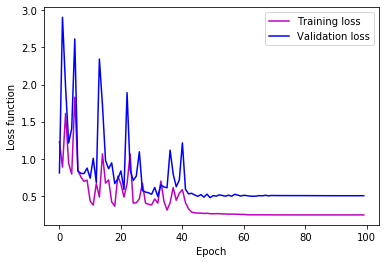

In [71]:
from IPython import embed
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(history.history['loss'],color='m',label='Training loss')
plt.plot(history.history['val_loss'],color='b',label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.legend(loc='upper right')
fig.savefig('training_validation.pdf')

#PlotHistory(loss_history,params=parameters)
# Params is a dict of parameters with name and values
# used for plotting


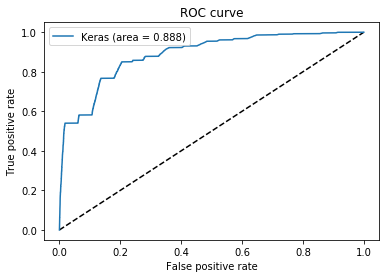

In [72]:
prediction = model.predict(X_test)
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, prediction,sample_weight=w_test)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

from IPython import embed
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='XGBoost (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
fig.savefig("ROC_curve.pdf")
plt.show()


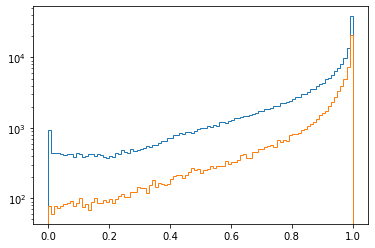

In [73]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.hist(prediction[y_test==0],histtype=("step"),bins=100)
plt.hist(prediction[y_test==1],histtype=("step"),bins=100)
plt.yscale('log') 
fig.savefig("prediction.pdf", dpi = 300)

In [25]:
# evaluate the model
scores = model.evaluate(X_test, y_test, sample_weight=w_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

9100/9100 - 7s - loss: 0.4168 - binary_accuracy: 0.3900 - auc: 0.6453 - precision: 0.3052 - recall: 0.9396 - 7s/epoch - 720us/step
binary_accuracy: 39.00%


In [ ]:
# save model and architecture to single file
model.save("model_dnn_threesignal")
print("Saved model to disk")